# UW Neural Data Challenge Intro

## Getting started
Below I will load in the dataset, create a very simple model, measure its performance, then use the model to predict responses on the test images, then save those responses as a submission ready to upload to Kaggle.

### Training data


In [4]:
#load the train data with popular tool pandas
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt 
%matplotlib inline

#load the stimuli with numpy
stim = np.load('input_files/stim.npy')
df = pd.read_csv('input_files/train.csv')
df.index = df.Id#turn the first col to index
df = df.iloc[:,1:]#get rid of first col that is now index
df.head()

,10_1_2018_0_0,10_1_2018_0_1,11_06_18_0_0,11_06_18_0_1,11_07_18_0_0,11_07_18_1_0,11_08_18_0_0,11_08_18_0_1,11_09_18_0_1,9_17_2018_0_0,9_17_2018_0_1,9_20_2018_0_0,9_21_2018_0_0,9_21_2018_0_1,9_26_2018_0_0,9_26_2018_0_1,9_28_2018_0_0,9_28_2018_0_1
Id,,,,,,,,,,,,,,,,,,
50,6.782330,1.414214,5.622356,1.172872,3.835296,9.107331,2.928577,1.002235,0.900420,6.174053,0.500000,3.813243,2.146952,1.668328,1.976085,0.788675,6.557439,1.414214
51,8.124038,1.000000,6.561819,0.477671,2.642316,6.778426,4.691500,0.596407,1.675685,6.269141,0.333333,3.589276,2.924137,2.961930,1.932416,0.166667,6.000000,0.000000
52,8.544004,0.000000,6.707088,0.892229,1.457884,4.877056,3.632468,1.812880,0.728759,6.771823,0.804738,4.632351,2.833196,1.696923,2.354642,0.955342,4.000000,0.000000
53,8.062258,2.000000,6.980861,0.699075,4.991866,9.280055,5.040368,0.181818,2.019465,6.531085,0.166667,4.502757,2.995157,1.199359,3.094110,2.474990,8.944272,0.000000
54,8.306624,1.414214,5.663736,0.284518,3.183899,8.674227,5.017551,0.272727,1.197206,6.007232,0.166667,3.573848,2.647334,1.646386,1.009994,1.288675,6.403124,0.000000


So here is the average square root of the number of spikes for the different recordings between 50-350 ms after the presentation of image 50 through 650. In each column is a recording: the first three numbers are the date of the recording, the next is the recording session number in a day, and the final number is 0 if it was a multiunit recording and 1 if it was a single unit. You will notice the multunit will have higher numbers of spikes than the single unit. Also if the multunit and single unit recordings were on the same date on the same session then the multunit and single unit are from the same recording just the single unit were the spikes isolated from the background activity and the multunit is the background activity. Often the background and single unit activity will be correlated. This might be helpful for building your models...

Functionally important things to note are: the stim number starts at 50 so you only have the responses to images with indexes 50 and above and some entries are nan because the cell was not shown that image.

### Stimuli
Now lets look at the stimuli:

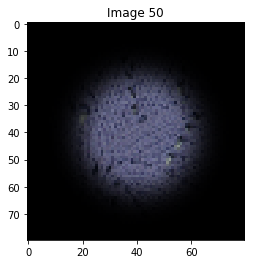

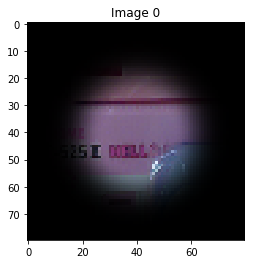

In [5]:
a_train_ind = 50
plt.imshow(stim[a_train_ind]);
plt.title('Image ' + str(a_train_ind));
plt.figure();
a_test_ind = 0
plt.imshow(stim[a_test_ind]);
plt.title('Image ' + str(a_test_ind));

The image on top has Id 50, which is from the training data, and so we know the spike number. So for example the single unit recorded on 10/1/2018 (2nd column in table above) had on average  $1.5^2$ spikes in response to this image. The ability of your algorithm to predict the responses to images 0-49 will determine your performance in the competition.

### Creating a simple model
To get you started and help you understand how to submit your results I will make a simple model below and submit its results. My hypothesis will be that all neurons are generally responding to the average color in the image. So I will take each image calculate the total amount of red, green, and blue then find the coefficients that best predict the respons of the neuron on the basis these three features. Quantitatively my hypothesis will be that the number of spikes is a linear combination of the amount of red green and blue in an image.


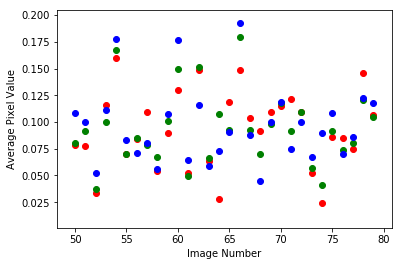

In [6]:
rgb = np.mean(stim, (1,2))#average RGB across rows and columns of each image
for i, c in enumerate(rgb.T):
    plt.scatter(range(len(c))[50:80], c[50:80], color=['r','g','b'][i], alpha=1);
plt.ylabel('Average Pixel Value');plt.xlabel('Image Number');

Just looking at the test a sample of the average RGB values for the images we can see some  have similar amounts of red green and blue (all points near each other) on different. Now lets take the RGB averagevalues from the training images and regress them on spike number.

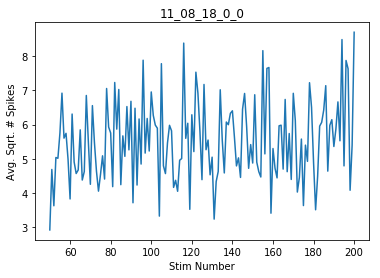

In [7]:
rec = df.iloc[:, 6].dropna()#use the command dropna as this cell only was shown 0-200 images
rec.plot();
plt.xlabel('Stim Number');plt.ylabel('Avg. Sqrt. # Spikes');
plt.title(rec.name);

The cell clearly responded with more spikes to some images than it did to others, lets see if we can get an intuition for what evoked a large number of spikes by looking at the images which evoked the greatest average number of spikes:
Lets look at the images the cell preferred the most:

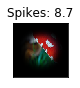

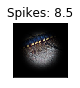

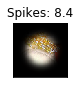

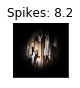

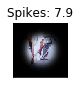

In [8]:
top_n = 5
best_resp_inds = rec.argsort()[::-1].values
for ind in best_resp_inds[:top_n]:
    plt.figure(figsize=(1,1))
    plt.imshow(stim[50:][ind]/np.max(stim[50:][ind]));
    plt.xticks([]);plt.yticks([])
    plt.title('Spikes: ' + str(np.round(rec.iloc[ind],1)))


What would you guess the cell prefers? How would you perform a computation on these images which approximated that intuition? Lets see how well the rgb model does.


In [9]:
rec = df.iloc[:, 6].dropna()#select the 6th column recording
x = rgb[50:][:len(rec)]#select the rgb averages for the training images 50:
y = rec.values#get the numerical values from the recording
A = np.hstack([x, np.ones((len(y), 1))])#create a matrix of predictors RGB and a constant for the intercept
coefs = np.linalg.lstsq(A, y, rcond=None)[0];#now regress our predictors on the responses and get the coefficients of the model A * coefs=y
fit_y = np.dot(A, coefs)#get the predicted values of this model.

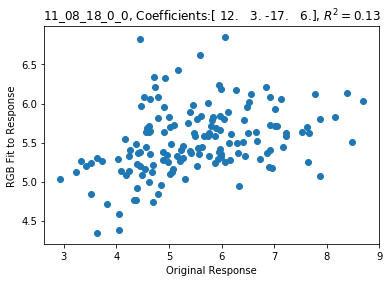

In [10]:
plt.scatter(y, fit_y);#scatter the true responses against the fit of the linear model
r = np.corrcoef(fit_y, y)[0,1]**2#get the correlation squared (fraction of variance explained)
plt.title(rec.name + ', Coefficients:' + str(np.round(coefs)) + 
          r', $R^2=$' + str(round(r,2)));
plt.xlabel('Original Response');
plt.ylabel('RGB Fit to Response');

So we account for a little over 10% of the variance using a very simple feature for the population recorded from on November 8th. The coefficient on red was 12 so when there was alot of red the cell tended respond the most, coefficient on green was 3 so green was associated with higher responses as well, whereas when blue was present the cell tended to fire very little on average. Can you think of other features you can extract from the image that might better predict responses?

### Example submission

Now lets organize all of our responses for a submission. The submission will be a matrix which has 50 rows for each of the held out respones and a column for each individual recording. 


In [11]:
test_preds = [] # create list to contain predictions
trainr2 = [] # list for fit to training data

#linear predictors rgb, and constant(intercept)
A = np.hstack([rgb, np.ones((rgb.shape[0], 1))]) 

for i in range(df.shape[1]): #for each recording
    rec = df.iloc[:, i].dropna()#get recording drop nan responses for images not shown
    y = rec.values # load responses into numpy array
    A_train = A[50:][:len(rec)]#get features of images we have responses for
    A_test = A[:50]#get features for test images you are making prediction on
    #train model i.e. regress rgb values onto responses
    coefs = np.linalg.lstsq(A_train, y, rcond=None)[0];
    fit_train_y = np.dot(A_train, coefs)#get the prediction for known responses
    trainr2.append(np.corrcoef(y, fit_train_y)[0,1])
    fit_test_y = np.dot(A_test, coefs)#use coefficients found for training data to make prediction on test data
    test_preds.append(fit_test_y)# append these predictions

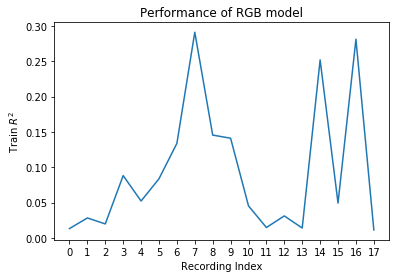

In [12]:
test_preds = np.array(test_preds)#convert predictions to array
trainr2= np.array(trainr2)
plt.plot(trainr2**2);plt.xlabel('Recording Index');plt.ylabel(r'Train $R^2$');
plt.xticks(range(len(trainr2)));plt.title('Performance of RGB model');

### Submitting results
Now the final step is putting your results into a submittable format

In [13]:
sdf = pd.DataFrame(test_preds.T)
sdf.columns = df.columns#replace the columns with the correct cell ids from training data
sdf.index.name = 'Id'
sdf.to_csv('sub.csv')#save to csv
sdf.head()#show top couple rows of submission

,10_1_2018_0_0,10_1_2018_0_1,11_06_18_0_0,11_06_18_0_1,11_07_18_0_0,11_07_18_1_0,11_08_18_0_0,11_08_18_0_1,11_09_18_0_1,9_17_2018_0_0,9_17_2018_0_1,9_20_2018_0_0,9_21_2018_0_0,9_21_2018_0_1,9_26_2018_0_0,9_26_2018_0_1,9_28_2018_0_0,9_28_2018_0_1
Id,,,,,,,,,,,,,,,,,,
0,7.872480,0.595127,6.163015,0.497040,3.137307,7.409312,5.249370,0.816530,1.407607,6.768578,0.403631,4.111969,3.064643,1.752595,2.285746,1.178161,6.018130,0.191368
1,7.813741,0.491782,6.040484,0.352563,3.585404,8.184495,6.231991,0.301066,1.006550,6.609808,0.316571,3.909398,2.952563,1.860525,1.782857,1.260709,7.604532,0.085246
2,7.941762,0.594214,6.203440,0.499033,3.132742,7.377352,5.445710,0.915789,1.429496,6.879706,0.415421,4.084730,3.144312,1.766072,2.509841,1.108468,5.990778,0.184685
3,7.864636,0.789445,6.107043,0.445449,2.951779,7.201266,4.821422,0.939443,1.343724,6.680236,0.363774,3.994020,3.072019,1.837692,2.280930,1.249072,5.514029,0.233642
4,7.871483,0.782379,6.146974,0.497627,2.856610,7.018910,4.581186,1.050221,1.470372,6.724897,0.395086,4.081200,3.089825,1.787110,2.391196,1.223071,5.149445,0.257844


And thats it, you are ready to submit. If you run this notebook on your own computer then it will save sub.csv to the current directory and you just need to upload that to submissions in Kaggle. If you fork this notebook and run it then it will save to 'Output' so if you open the notebook under the 'Kernels' then 'Your Work' tab then 'Output' tab you will see a button to submit your results, and thats it! 